<a href="https://colab.research.google.com/github/rashmic20/Phase5_Project/blob/main/Vader_on_Final_LDA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Phase 5 Project: Sentiment Analysis on text data taken from restaurant reviews from the Yelp.**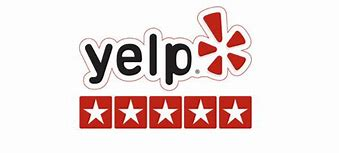

*Submitted by: Rashmi Chauhan
Data Science Live Cohort Oct June-Oct 2024*


The Analysis consists of  3 parts:
1. Exploratory analysis on the overall
   review trends across time
2. Latent Dirichlet Allocation (LDA) model to determine key topics among reviews
3. Calculate the polarity score and assign
  sentiment based on Vader NLP technique.


### Dataset

The dataset for this project is taken form Yelp’s open dataset.
It has 6,990,280 reviews about over 150,346 businesses.

Each row in the reviews dataframe consists of reviews data: business_id of the restaurant reviewed, star rating granted, number of [useful, funny, cool] votes, review text, and date.

Each row in the business dataframe consists of business data: business_id, business name, state, overall star rating, number of reviews, categories, and business status (open or closed).

I have further filtered the data to show analysis on the restaurant business in Florida state, and the time period is from 2020 to 2024.

#### Exploratory Data analysis

 ### 1.Distribution of User-Provided Star Ratings vs Business Average Star Ratings

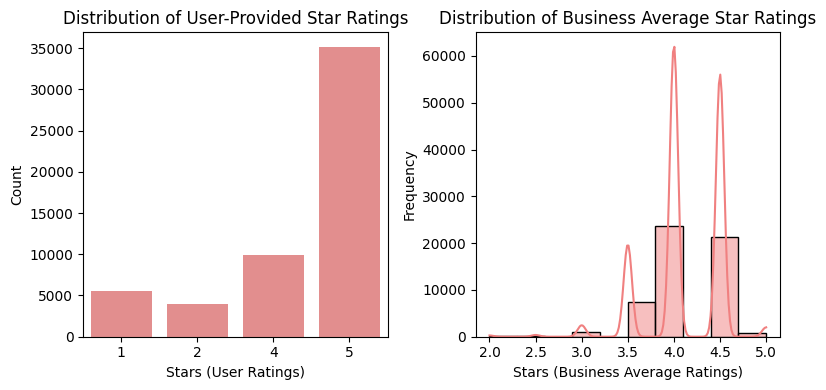

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
red_color = "#F08080"

# Distribution of user-provided star ratings (stars_x)
plt.subplot(1, 2, 1)
sns.countplot(x='stars_x', data=df_filtered, color=red_color)
plt.title('Distribution of User-Provided Star Ratings')
plt.xlabel('Stars (User Ratings)')
plt.ylabel('Count')

# Distribution of business average star ratings (stars_y)
plt.subplot(1, 2, 2)
sns.histplot(df_filtered['stars_y'], bins=10, kde=True, color=red_color)
plt.title('Distribution of Business Average Star Ratings')
plt.xlabel('Stars (Business Average Ratings)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2. Correlation Between Review Count and Business Average Rating

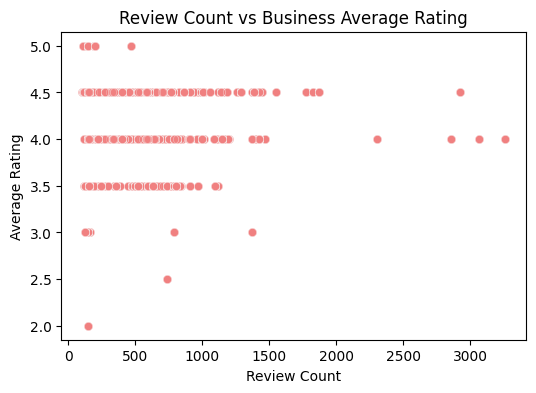

In [116]:
plt.figure(figsize=(6, 4))
red_color = "#F08080"
sns.scatterplot(x='review_count', y='stars_y', data=df_filtered, alpha=0.3, color=red_color)
plt.title('Review Count vs Business Average Rating')
plt.xlabel('Review Count')
plt.ylabel('Average Rating')
plt.show()


### 3. Top 20 Categories

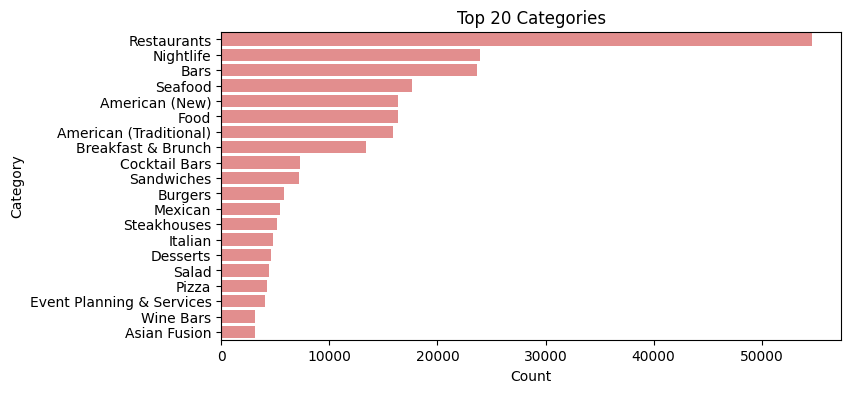

In [125]:
plt.figure(figsize=(8, 4))
"#F08080"
all_categories = df_filtered['categories'].str.split(',').explode().str.strip()  # Split and explode the categories
top_categories = all_categories.value_counts().head(20)  # Get the top 20 categories
sns.barplot(x=top_categories.values, y=top_categories.index, color=red_color)
plt.title('Top 20 Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


### 4. Review Length vs User Ratings

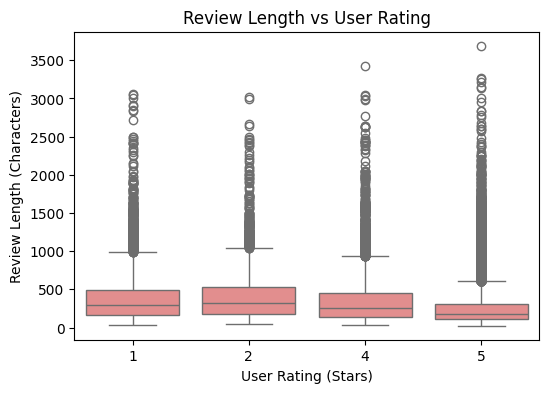

In [129]:
plt.figure(figsize=(6, 4))
red_color = "#F08080"
sns.boxplot(x='stars_x', y='review_length', data=df_filtered, color=red_color)
plt.title('Review Length vs User Rating')
plt.xlabel('User Rating (Stars)')
plt.ylabel('Review Length (Characters)')
plt.show()

### 5. Distribution of Reviews Over Time

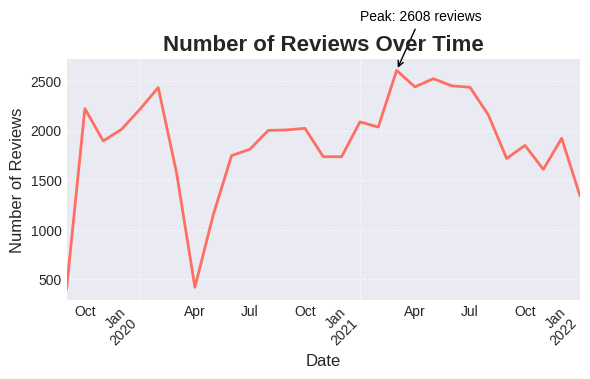

In [137]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'], errors='coerce')

# Set a style for the plot
plt.style.use('seaborn-darkgrid')

# Plot the number of reviews over time by month
plt.figure(figsize=(6, 4))
review_counts_by_month = df_filtered['date'].dt.to_period("M").value_counts().sort_index()

# Plot with enhancements
ax = review_counts_by_month.plot(kind='line', linewidth=2, color='#ff6f61')  # Thicker line and custom color

# Add titles and labels
plt.title('Number of Reviews Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Customize x-ticks
plt.xticks(rotation=45, ha='right')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Highlighting the highest review count
max_reviews = review_counts_by_month.max()
max_date = review_counts_by_month.idxmax()

ax.annotate(f'Peak: {max_reviews} reviews', xy=(max_date, max_reviews),
            xytext=(max_date - 2, max_reviews + 500),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Insights:
* The distribution of user-provided star ratings shows that the most
  common ratings are on the higher end (4 and 5 stars).
* There is no clear linear relationship between the number of reviews
  and the average business rating.
* The most common categories are American, Bars, Seafood, and
  Breakfast & Brunch.
* Reviews that are either very positive (5 stars) or very negative (1
  star) tend to be longer, indicating that customers may feel more inclined to elaborate when they have strong opinions.
* There is a noticeable increase in the number of reviews over time,
  especially in the last few years. This could indicate that the platform or business has grown in popularity.
* The noticeable dips in review patterns is during the pandemic
  period, potentially reflecting shifts in consumer behavior.
* The higher frequency of 4 and 5-star reviews could indicate  
  reviewer bias, where people who are more likely to leave reviews tend to have positive experiences.


##**LDA and VADER Sentiment Analysis on the Restaurant reviews.**

Topic Modeling is an unsupervised learning approach to clustering documents, to discover topics based on their contents. LDA, or Latent Derelicht Analysis is a probabilistic model, and to obtain cluster assignments, it uses two probability values: P( word | topics) and P( topics | documents). These values are calculated based on an initial random assignment, after which they are repeated for each word in each document, to decide their topic assignment. In an iterative procedure, these probabilities are calculated multiple times, until the convergence of the algorithm.

For each review, lets extract the dominant topic using our LDA model followed by VADER sentiment analysis to get the sentiment score (positive, neutral, or negative). After assigning sentiment scores to each review, calculate the sentiment distribution for each topic.

Sentiment analysis, also known as opinion mining, is a method for identifying the positive, negative, or neutral tone of a piece of text,it analyzes words and phrases to determine if a review is positive, negative, or neutral. After we identified positive and negative sentiments, we would like to further explore what specific messages they conveyed. For example, among all negative reviews, what aspects of restaurants do they talk about the most? Do they complain about food, services or environments?

To solve this problem, we used topic modeling to identify key messages or topics customers are talking about. We determine number of topics based on coherence score, which measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. Then we identified the topic based on the word distribution of the topic.

In [108]:
import pandas as pd
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Ignore specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Replace DeprecationWarning with other warning types as needed

# Load the cleaned dataset
df_filtered = pd.read_csv('filtered_reviews.csv')

# Check for the quick summary
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54611 entries, 0 to 54610
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_id      54611 non-null  object 
 1   user_id        54611 non-null  object 
 2   business_id    54611 non-null  object 
 3   stars_x        54611 non-null  int64  
 4   date           54611 non-null  object 
 5   name           54611 non-null  object 
 6   city           54611 non-null  object 
 7   state          54611 non-null  object 
 8   postal_code    54611 non-null  int64  
 9   latitude       54611 non-null  float64
 10  longitude      54611 non-null  float64
 11  stars_y        54611 non-null  float64
 12  review_count   54611 non-null  int64  
 13  categories     54611 non-null  object 
 14  cleaned_text   54611 non-null  object 
 15  review_length  54611 non-null  int64  
dtypes: float64(3), int64(4), object(9)
memory usage: 6.7+ MB


### Data Preprocessing for Text Data

 Let's preprocessing text data to make it ready for topic modeling and sentiment analysis.
 1. Stop word removal: Removing common words (like "the", "is", "and") from the reviews that don't add meaningful information.
 2. Tokenization: The text in each review is split into individual words (tokens).
 3. Creating Bigrams and Trigrams: allows frequently co-occurring words to be treated as single entities.
 4. Lemmatization: Reducing each word to its base form
 5. Also Part-of-Speech Filtering for keping nouns, adjectives, verbs, and adverbs.

In [32]:
# Pipeline for data preprocessing on text data

import nltk
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
import spacy

# Load necessary resources
nltk.download('stopwords')
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Tokenization and stopword removal
texts = [simple_preprocess(doc) for doc in df_filtered['cleaned_text']]
texts = [[word for word in doc if word not in stop_words] for doc in texts]

# Creating bigrams and trigrams
bigram = Phrases(texts, min_count=5, threshold=100)
trigram = Phrases(bigram[texts], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]

# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

texts_lemmatized = lemmatization(texts_bigrams)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common Words: [('food', 38803), ('good', 34220), ('great', 30216), ('place', 25313), ('get', 23848), ('go', 22734), ('order', 22228), ('service', 21001), ('come', 20103), ('time', 18511), ('back', 14763), ('make', 14054), ('restaurant', 13803), ('well', 13378), ('try', 12877), ('drink', 12509), ('amazing', 12410), ('love', 11531), ('also', 10824), ('wait', 10540)]


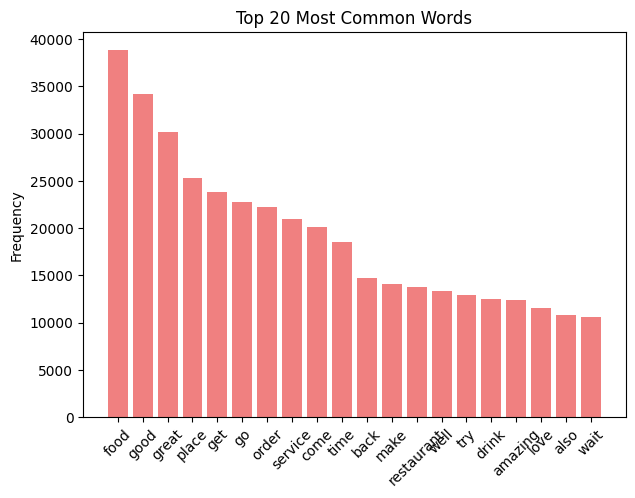

In [99]:
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Flatten the list of tokens
all_words = [word for sublist in texts_lemmatized for word in sublist]

# Step 2: Count the frequency of each word
word_freq = Counter(all_words)

# Step 3: Display the top 20 most common words
most_common_words = word_freq.most_common(20)
print("Most Common Words:", most_common_words)

# Step 4: Visualize the word frequencies with a bar plot
words, counts = zip(*most_common_words)
plt.figure(figsize=(7, 5))
plt.bar(words, counts, color='#F08080')
plt.title('Top 20 Most Common Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


POS Percentages: {'NOUN': 46.82913993382868, 'VERB': 17.77705215620296, 'ADJ': 21.17316237733753, 'ADV': 9.175937628297497}


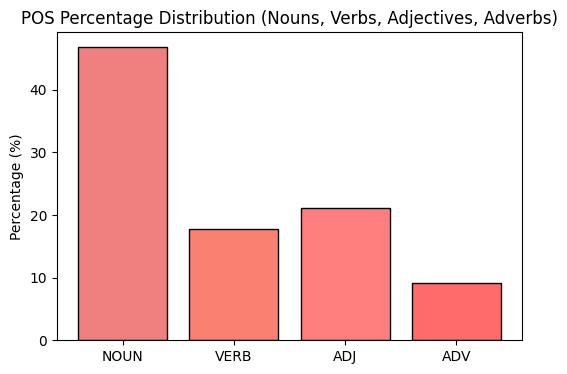

In [100]:
import spacy
import matplotlib.pyplot as plt

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to count POS categories
def count_pos_percentages(texts):
    total_words = 0
    pos_counts = {'NOUN': 0, 'VERB': 0, 'ADJ': 0, 'ADV': 0}

    for doc in texts:
        spacy_doc = nlp(" ".join(doc))  # Join tokens and process with SpaCy
        for token in spacy_doc:
            if token.pos_ in pos_counts:  # Only count NOUN, VERB, ADJ, ADV
                pos_counts[token.pos_] += 1
            total_words += 1  # Keep track of total words

    # Calculate percentages for each POS
    pos_percentages = {pos: (count / total_words) * 100 for pos, count in pos_counts.items()}

    return pos_percentages

# Call the function on the lemmatized texts
pos_percentages = count_pos_percentages(texts_lemmatized)

# Display the percentages
print("POS Percentages:", pos_percentages)
# Define the colors
colors = ['#F08080', '#FA8072', '#FF7F7F', '#FF6A6A']

# Visualize the POS percentages
plt.figure(figsize=(6, 4))
plt.bar(pos_percentages.keys(), pos_percentages.values(), color = colors, edgecolor ='black')
plt.title('POS Percentage Distribution (Nouns, Verbs, Adjectives, Adverbs)')
plt.ylabel('Percentage (%)')
plt.show()


In [44]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Create a dictionary and corpus for LDA
id2word = Dictionary(texts_lemmatized)
corpus = [id2word.doc2bow(text) for text in texts_lemmatized]

# Build LDA model and evaluate coherence
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=4, random_state=100, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Coherence model
coherence_model = CoherenceModel(model=lda_model, texts=texts_lemmatized, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.5015917155704872


Lets check the the topic-word distributions and the topic probabilities.

In [47]:
# Get the top words for each topic
topics = lda_model.print_topics(num_words=10)  # num_words specifies how many words to display per topic
for topic in topics:
    print(topic)

(0, '0.019*"get" + 0.018*"order" + 0.016*"go" + 0.015*"come" + 0.015*"table" + 0.013*"wait" + 0.013*"time" + 0.013*"take" + 0.012*"say" + 0.012*"food"')
(1, '0.041*"food" + 0.040*"great" + 0.035*"good" + 0.030*"place" + 0.024*"service" + 0.017*"amazing" + 0.015*"go" + 0.015*"love" + 0.013*"back" + 0.013*"definitely"')
(2, '0.033*"parking" + 0.022*"view" + 0.018*"bar" + 0.013*"room" + 0.012*"beach" + 0.012*"hotel" + 0.011*"lot" + 0.011*"sit" + 0.010*"area" + 0.010*"water"')
(3, '0.020*"order" + 0.015*"good" + 0.015*"get" + 0.013*"fry" + 0.011*"flavor" + 0.010*"also" + 0.010*"sauce" + 0.010*"taste" + 0.009*"side" + 0.009*"chicken"')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The LDA topics that are generated show the most frequent and relevant words for each topic, along with their weights, which represent the probability of those words being part of that specific topic.

### Lets label these Topics based on frequency of words and weights assigned to them:
* 1: Order & Dining Experience: Customer experience with ordering, waiting times, and interactions around the table.
* 2: Overall Experience: Positive reviews related to the quality of food and service, with a high likelihood of customers recommending the restaurant.
* 3: Ambiance & Location: Comments about the restaurant's ambiance, view, and parking or proximity to scenic spots like the beach.
* 4: Food Quality & Taste: Focus on the taste and quality of food, with emphasis on specific dishes and flavors.

Now lets analyze the sentiment score associated with each topic to understand if customers are satisfied with specific aspects like food, service, or the ambiance.

In [70]:
# Define a dictionary to map topic numbers to labels
topic_labels = {
    0: "Order & Dining",
    1: "Overall Experience, ",
    2: "Ambiance & Location",
    3: "Food taste & Flavor" # Add a label for any remaining topics
}

# Create a new column 'Topic_Label' by mapping the 'Dominant_Topic' column
df_filtered['Topic_Label'] = df_filtered['Dominant_Topic'].map(topic_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualizing these topics with a tool like pyLDAvis helps to see how the topics are distributed across reviews and their importance.

In [71]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to extract topics and perform sentiment analysis
def get_sentiment_and_topics(ldamodel, corpus, texts):
    analyzer = SentimentIntensityAnalyzer()
    topic_sentiments = []

    for i, row in enumerate(ldamodel[corpus]):
        dominant_topic = sorted(row[0], key=lambda x: x[1], reverse=True)[0][0]
        sentiment = analyzer.polarity_scores(texts[i])['compound']
        topic_sentiments.append((dominant_topic, sentiment))

    return topic_sentiments

# Get the sentiment scores and dominant topics for each review
df_filtered['Topic_Sentiment'] = get_sentiment_and_topics(lda_model, corpus, df_filtered['cleaned_text'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# Save the visualization to an HTML file
pyLDAvis.save_html(lda_vis_data, 'lda_visualization.html') # Save before download

# Download the HTML file using google.colab.files
from google.colab import files
files.download('lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the data for visualization
lda_vis_data = gensimvis.prepare(lda_model, corpus, id2word, mds='tsne')

# Enable pyLDAvis to display in the notebook
pyLDAvis.enable_notebook()

# Display the visualization
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


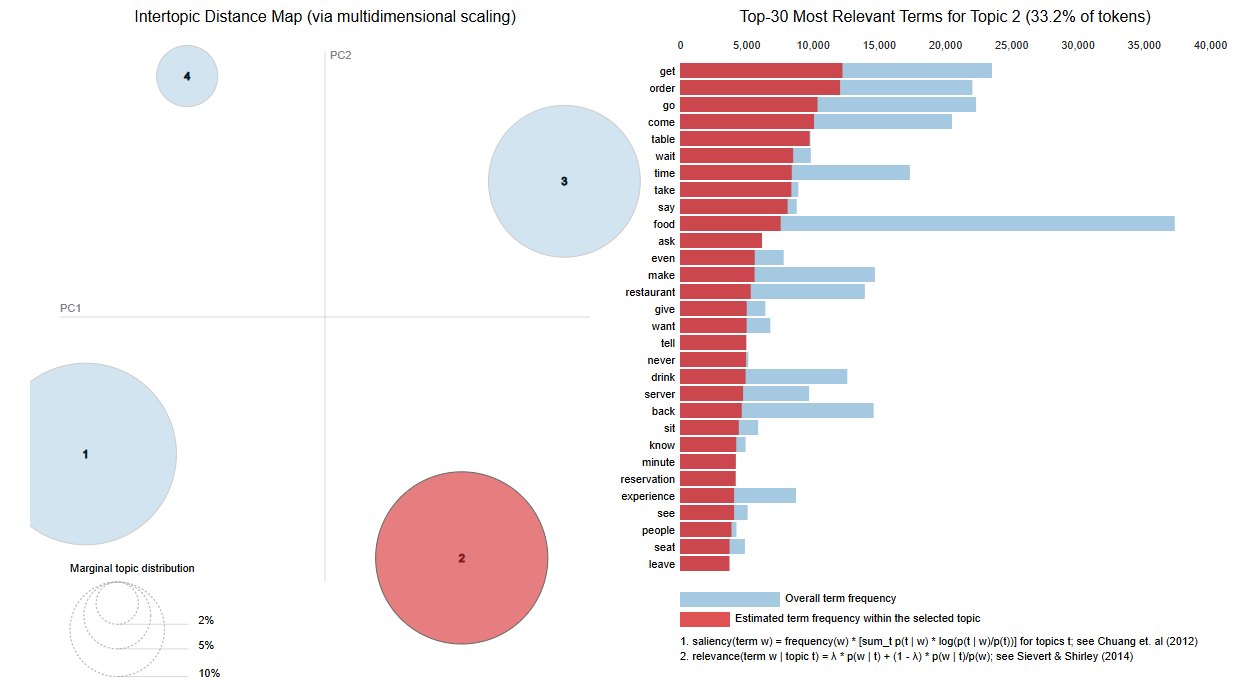

In [105]:
from collections import defaultdict
import pandas as pd

# Create a dictionary to store topic sentiment counts
topic_sentiment = defaultdict(lambda: {'Positive': 0, 'Negative': 0, 'Neutral': 0})

# Function to assign sentiment to a topic
def assign_sentiment_to_topic(ldamodel, corpus, texts, sentiment_scores):
    for i, row in enumerate(ldamodel[corpus]):
        # Get dominant topic for the document
        dominant_topic = sorted(row[0], key=lambda x: x[1], reverse=True)[0][0]
        # Get sentiment of the corresponding review
        sentiment = sentiment_scores[i][1] # Access sentiment from topic_sentiments tuple
        # Update the topic_sentiment dictionary with the review's sentiment
        if sentiment > 0.05:
          topic_sentiment[dominant_topic]['Positive'] += 1
        elif sentiment < -0.05:
          topic_sentiment[dominant_topic]['Negative'] += 1
        else:
          topic_sentiment[dominant_topic]['Neutral'] += 1

# Assuming topic_sentiments is the output from get_sentiment_and_topics
topic_sentiments = get_sentiment_and_topics(lda_model, corpus, df_filtered['cleaned_text']) # Assuming you have this variable available from previous code

# Create 'VADER_Sentiment' column in df_filtered
df_filtered['VADER_Sentiment'] = [sentiment for topic, sentiment in topic_sentiments]

# Call the function to assign sentiment to topics
assign_sentiment_to_topic(lda_model, corpus, df_filtered['cleaned_text'], topic_sentiments)

# Convert topic_sentiment dictionary to a DataFrame for easier analysis
topic_sentiment_df = pd.DataFrame(topic_sentiment).T
topic_sentiment_df.columns = ['Positive', 'Negative', 'Neutral']

# Use the display function from pandas to show the dataframe
display(topic_sentiment_df)


,Positive,Negative,Neutral
1,32893,338,167
0,8601,2832,287
3,8816,429,87
2,122,12,27


The table is showing the distribution of sentiment (Positive, Negative, Neutral) for each topic. While many customers are happy with wait times and efficiency, there’s a significant amount of negative feedback, indicating this might be an area for improvement.



lets check the distributipn of ratimngs fpor reviews to cjeck thr overall distribution
new_var filtered_reviews.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


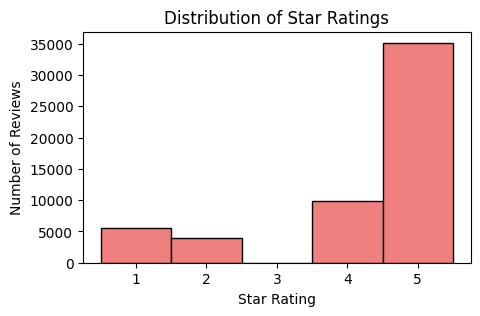

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe
df_filtered = pd.read_csv('filtered_reviews.csv')

# Check distribution of star ratings
plt.figure(figsize=(5, 3))
plt.hist(df_filtered['stars_x'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black',color='#F08080')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Star Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

The ratings of each review also follow the same trend, with a significant skew towards 5-star ratings, followed by 4-star rating

Lets assign a class to each sentiment score

In [104]:
# Separate the topics and sentiment into different columns
df_filtered[['Dominant_Topic', 'Sentiment_Score']] = pd.DataFrame(df_filtered['Topic_Sentiment'].tolist(), index=df_filtered.index)

# Calculate Positive and Negative Sentiment Scores
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
  scores = analyzer.polarity_scores(text)
  return scores['pos'], scores['neg']

df_filtered[['Positive_Sentiment', 'Negative_Sentiment']] = df_filtered['cleaned_text'].apply(get_sentiment_scores).apply(pd.Series)

# Save the DataFrame for Tableau import
df_filtered.to_csv('topics_and_sentiments_for_tableau.csv', index=False)

KeyError: 'Topic_Sentiment'

# New Section

Apply the function and create the new column

In [103]:
# Separate the topics and sentiment into different columns
df_filtered[['Dominant_Topic', 'Sentiment_Score']] = pd.DataFrame(df_filtered['Topic_Sentiment'].tolist(), index=df_filtered.index)

# Save the DataFrame for Tableau import
df_filtered.to_csv('topics_and_sentiments_for_tableau.csv', index=False)


KeyError: 'Topic_Sentiment'

In [102]:
df_filtered.head(1)

,review_id,user_id,business_id,stars_x,date,name,city,state,postal_code,latitude,longitude,stars_y,review_count,categories,cleaned_text,review_length
0,xZqAdOML_vUoe2Jva1XEXg,_vV7CWVtVbYaHH7HT2EUvA,6vWKezveJpsWgjl5Cd3l-g,5,9/27/2019 19:43,Pal Campo Restaurant Tampa,Tampa,FL,33634,28.031686,-82.541086,3.0,164,"Latin American, Puerto Rican, Caribbean, Resta...",attentive staff amazing authentic spanish food...,81


In [101]:
# 1. Add Sentiment Score Class
def assign_sentiment_class(score):
  if score > 0:
    return 'Positive'
  elif score < 0:
    return 'Negative'
  else:
    return 'Neutral'
topics_and_sentiments_for_tableau['Sentiment_Score_Class'] = topics_and_sentiments_for_tableau['Sentiment_Score'].apply(assign_sentiment_class)

NameError: name 'topics_and_sentiments_for_tableau' is not defined

Let's generate a word cloud for each review to verify the sentiment.

In [9]:
!pip install wordcloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, sentiment):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Sentiment: {sentiment}")  # Add sentiment as title
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


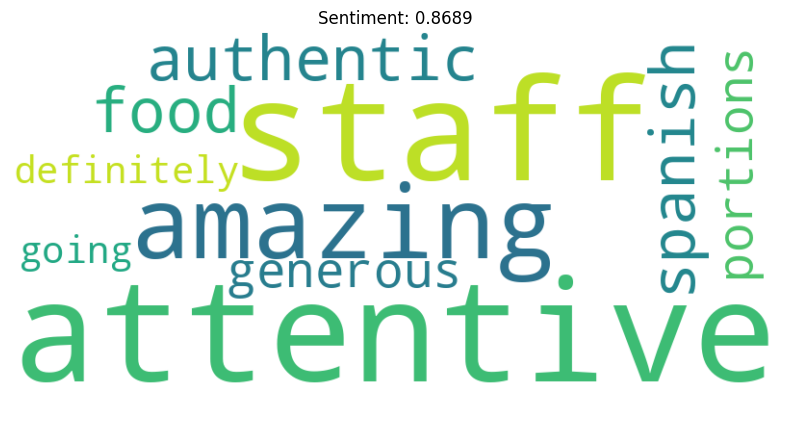

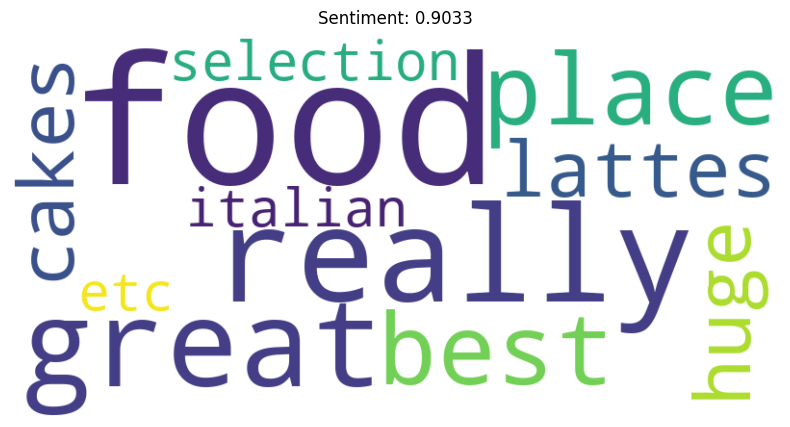

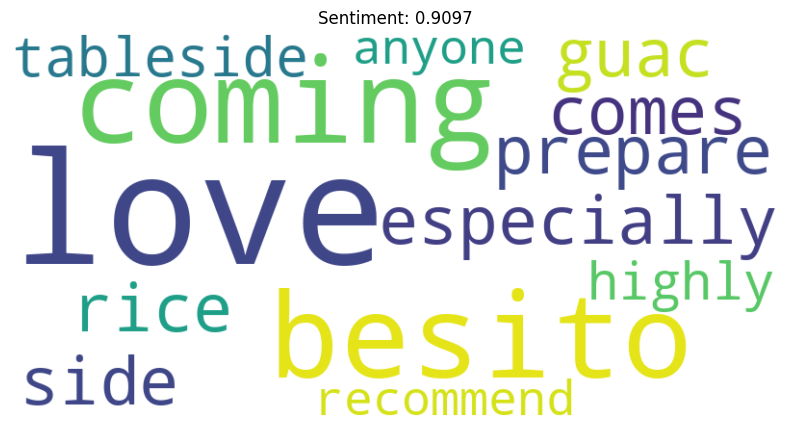

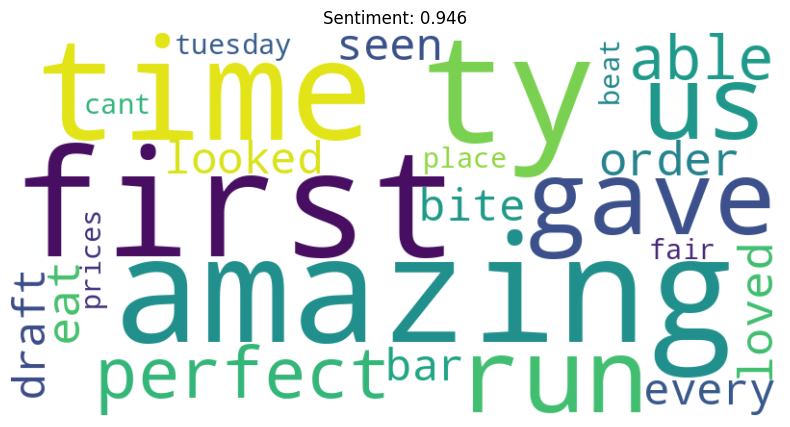

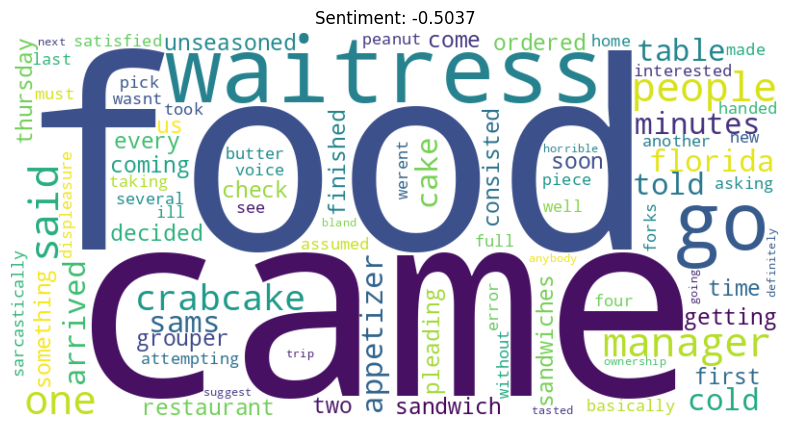

KeyboardInterrupt: 

In [86]:
for index, row in df_filtered.iterrows():
    text = row['cleaned_text']  # Use the cleaned review text
    sentiment = row['Sentiment_Score']  # Get the sentiment score
    generate_wordcloud(text, sentiment)

# Move the if statement outside the for loop and increment the count variables
if positive_count >= 2 and negative_count >= 2:
    break  # Stop after generating 2 for each sentiment

In [ ]:
!pip install wordcloud
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Sample DataFrame (replace with your actual data)
data = {'reviews': ['The food was delicious and the service was excellent!',
                   'The restaurant was dirty and the food was terrible.',
                   'The ambiance was nice but the food was average.',
                   'I had a great time and the food was amazing!'],
        'sentiment_score': [4, 1, 2, 5]}
df = pd.DataFrame(data)

# Create word cloud for positive sentiment
positive_words = ' '.join(df[df['sentiment_score'] > 3]['reviews'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Create word cloud for negative sentiment
negative_words = ' '.join(df[df['sentiment_score'] < 3]['reviews'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Function to convert word cloud to frequency table
def wordcloud_to_frequencies(wordcloud):
  word_counts = Counter(wordcloud.words_)
  df_freq = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])
  df_freq.index.name = 'Word'
  return df_freq

# Convert word clouds to frequency tables
df_positive_freq = wordcloud_to_frequencies(wordcloud_positive)
df_negative_freq = wordcloud_to_frequencies(wordcloud_negative)

# Save frequency tables to CSV files
df_positive_freq.to_csv('positive_wordcloud.csv')
df_negative_freq.to_csv('negative_wordcloud.csv')

# Display word clouds (optional)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Inference from text Analytics:**

1. The word "food" is the most frequent, indicating that the primary reason people are reviewing the restaurant revolves around the quality and experience of the food itself. This suggests that food quality is the dominant factor that influences customer reviews.

2. Words like "good," "great," "amazing," and "love" indicate that a significant portion of the reviews contains positive sentiment.

3. The word "wait" also appears in the top 20, indicating that wait times are a frequent topic of discussion. It's an operational area that need attention.

4. The presence of the word "back" suggests that customers often mention their desire to return or share their previous dining experiences. This indicates a level of customer loyalty, where diners are willing to come back if they had a positive experience.

5. The words "service" and "place" appear frequently, this suggests that customers are not only focused on the food but also place importance on how they are treated by staff and the ambiance of the location.

6. Neutral sentiment may be a signal of early-stage dissatisfaction, giving the restaurant an opportunity to address concerns before they lead to negative reviews.

### References